# Geodist Python usage

This notebook demos the public `geodist` Python API. It keeps to the exported surface
available from `import geodist` (no private Rust module access).

Prerequisites when running from the repo root:
- `cd pygeodist && uv sync --all-extras`
- `uv run maturin develop` to build the extension module before importing

In [16]:
from geodist import (
    EARTH_RADIUS_METERS,
    BoundingBox,
    GeodesicResult,
    Point,
    Point3D,
    geodesic_distance,
    geodesic_distance_3d,
    geodesic_with_bearings,
    hausdorff,
    hausdorff_clipped,
    hausdorff_directed,
)

EARTH_RADIUS_METERS


6371008.8

## Points and tuples

Create latitude/longitude points (degrees) and optional altitude for 3D points.
Each wrapper can round-trip to tuples for interoperability.


In [17]:
nyc = Point(40.7128, -74.0060)
london = Point(51.5074, -0.1278)

print('NYC tuple:', nyc.to_tuple())
print('London tuple:', london.to_tuple())
print('NYC repr:', nyc)

# 3D point with altitude in meters
viewpoint = Point3D(37.7335, -119.5580, 2693.0)
print('3D point:', viewpoint)


NYC tuple: (40.7128, -74.006)
London tuple: (51.5074, -0.1278)
NYC repr: Point(lat=40.7128, lon=-74.006)
3D point: Point3D(lat=37.7335, lon=-119.558, altitude_m=2693.0)


## Great-circle distance and bearings

Use `geodesic_distance` for the spherical fast path (mean-radius approximation) and
`geodesic_with_bearings` for distance plus initial/final bearings.


In [18]:
nyc_to_london_m = geodesic_distance(nyc, london)
bearings: GeodesicResult = geodesic_with_bearings(nyc, london)

print(f'NYC to London: {nyc_to_london_m/1000:.1f} km')
print(f'  initial bearing: {bearings.initial_bearing_deg:.1f} deg')
print(f'  final bearing:   {bearings.final_bearing_deg:.1f} deg')


NYC to London: 5570.2 km
  initial bearing: 51.2 deg
  final bearing:   108.3 deg


## 3D straight-line distance (ECEF chord)

`geodesic_distance_3d` computes a straight-line chord through space using
latitude/longitude in degrees and altitude in meters.


In [19]:
# Yosemite Valley viewpoint to Yosemite Falls overlook (approximate)
valley_floor = Point3D(37.7331, -119.5586, 1200.0)
clifftop = Point3D(37.7335, -119.5580, 2693.0)

line_of_sight_m = geodesic_distance_3d(valley_floor, clifftop)
print(f'Line-of-sight distance: {line_of_sight_m:.1f} m')


Line-of-sight distance: 1494.6 m


## Hausdorff distance over point sets

Hausdorff compares two sets of points; directed answers
"how far is set A from being covered by B?" while symmetric checks the max distance either direction.


In [20]:
trail_a = [
    Point(47.6205, -122.3493),
    Point(47.6220, -122.3470),
    Point(47.6235, -122.3440),
]
trail_b = [
    Point(47.6200, -122.3490),
    Point(47.6215, -122.3465),
    Point(47.6230, -122.3435),
]

symmetric = hausdorff(trail_a, trail_b)
directed_ab = hausdorff_directed(trail_a, trail_b)
directed_ba = hausdorff_directed(trail_b, trail_a)

print(f'Symmetric Hausdorff: {symmetric.distance_m:.2f} m')
print(f'Directed A->B:       {directed_ab.distance_m:.2f} m')
print(f'Directed B->A:       {directed_ba.distance_m:.2f} m')

Symmetric Hausdorff: 67.05 m
Directed A->B:       67.05 m
Directed B->A:       67.05 m


## Bounding-box clipping to ignore outliers

Clipped variants restrict evaluation to a latitude/longitude envelope,
which is useful when one set contains distant outliers you want to ignore.


In [21]:
outlier = Point(10.0, 10.0)
trail_b_with_outlier = trail_b + [outlier]

bbox = BoundingBox(47.61, 47.64, -122.36, -122.33)

raw_hausdorff = hausdorff(trail_a, trail_b_with_outlier)
clipped_hausdorff = hausdorff_clipped(trail_a, trail_b_with_outlier, bbox)

print(f'Hausdorff with outlier: {raw_hausdorff.distance_m/1000:.2f} km')
print(f'Clipped Hausdorff:      {clipped_hausdorff.distance_m:.2f} m')

Hausdorff with outlier: 12074.82 km
Clipped Hausdorff:      67.05 m


## Pretty route visualizations

Use the experiments helper to turn origin/destination pairs into a PNG. The bundled `routes.example.json` shows the expected format: a top-level `routes` array with `origin`/`destination` coordinates and optional `label` or `distance_km`.


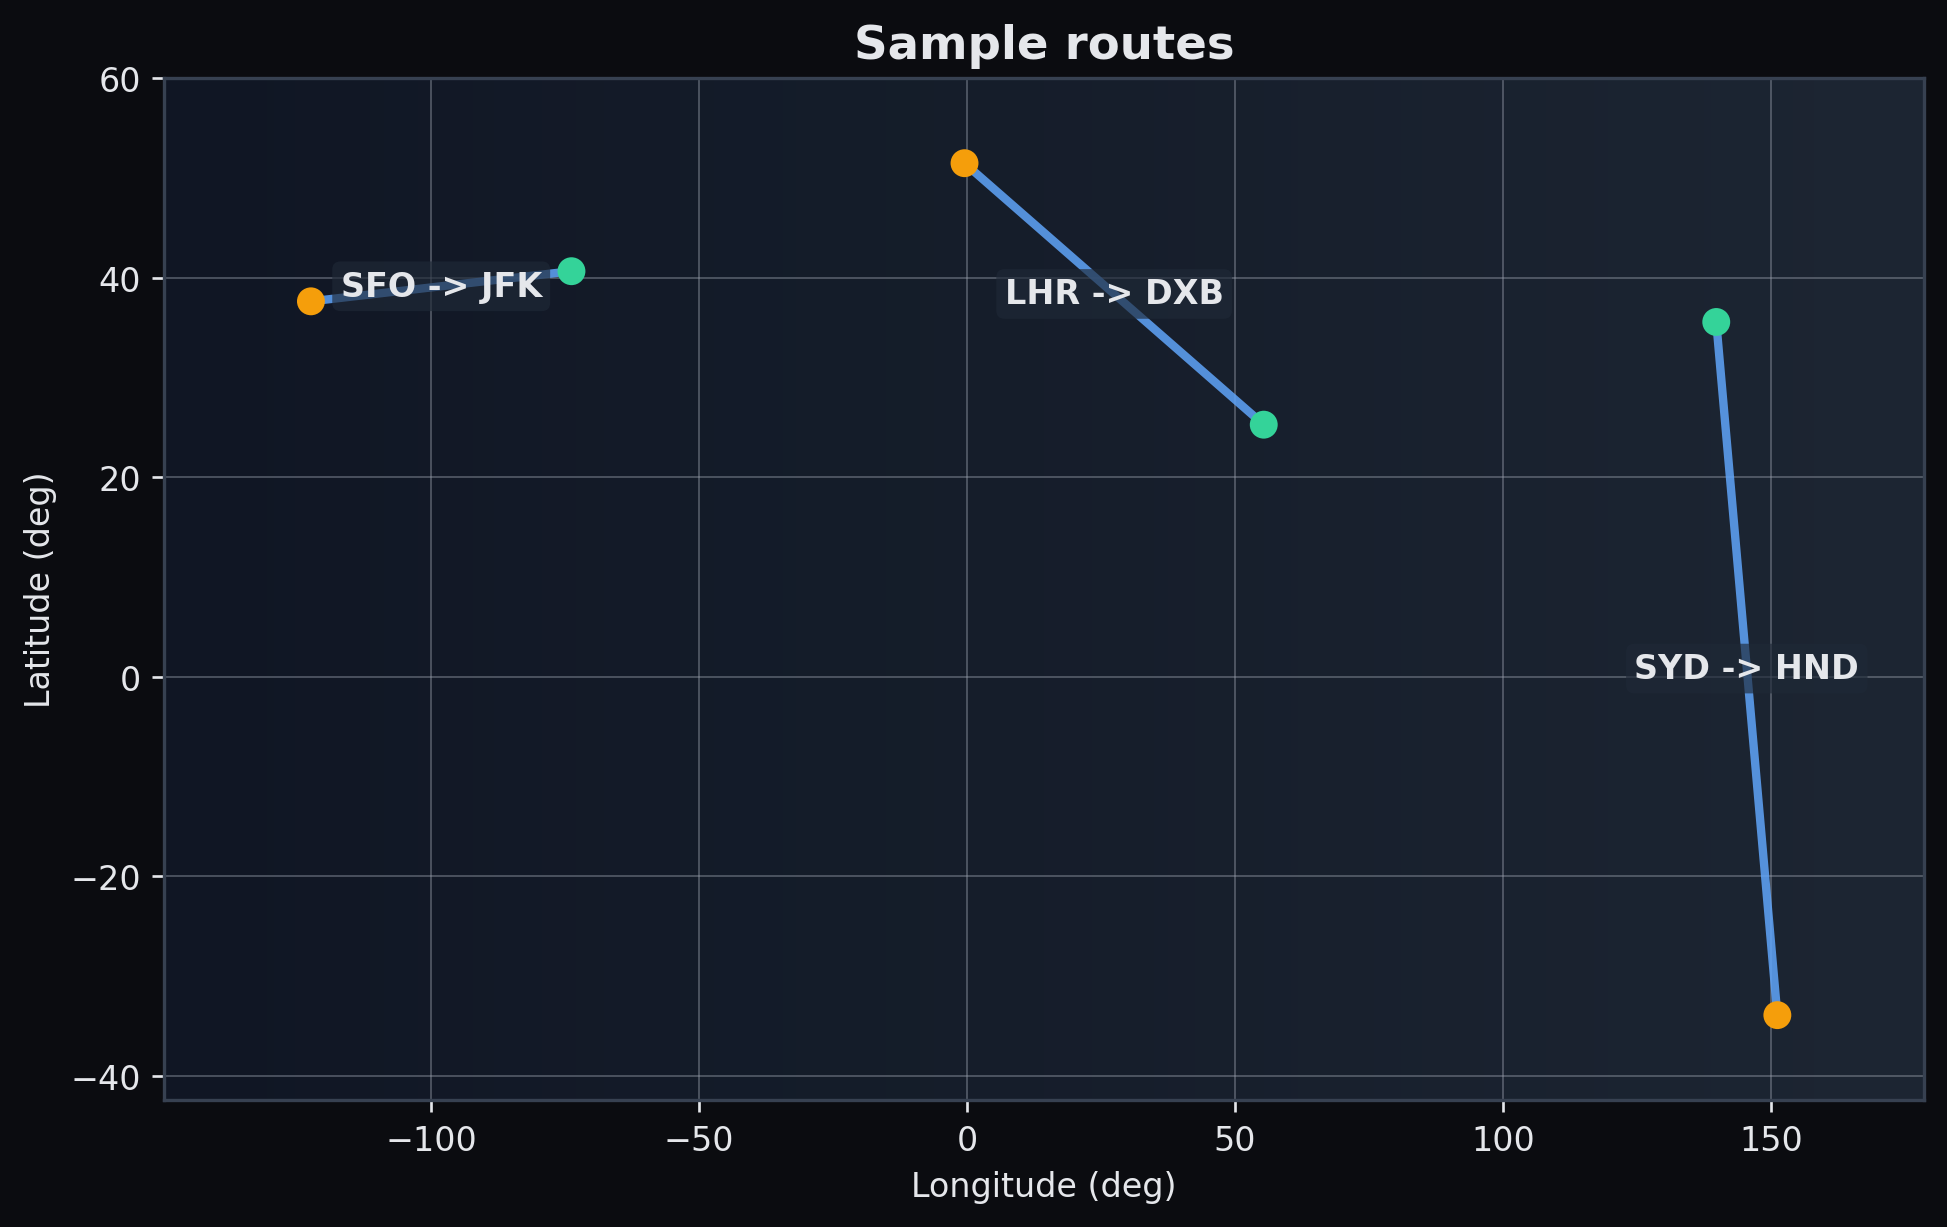

In [22]:
from pathlib import Path

from experiments.viz import load_routes, render_routes_figure

routes_path = (Path.cwd() / "../routes.example.json").resolve()
routes = load_routes(routes_path)
fig = render_routes_figure(routes, theme='dusk', title='Sample routes')